# Court Dynamics: Predicting Player Positions and Exploring Role Structure

In this notebook we use the `basketball.db` dataset to:

1. Build a clean player-season dataset with per-game and efficiency statistics.
2. Train and compare baseline classifiers (Logistic Regression, SVM, Random Forest) to predict players' positions (G/F/C).
3. Extend the feature space with physical attributes (height and weight) and evaluate their impact on performance.
4. Use PCA and clustering to explore the latent structure of player roles and compare it to the labeled positions.
5. Conclusion 

The structure follows the methods and tools introduced in class (train/validation/test splits, standardization, GridSearchCV, PCA, KMeans, etc.).

---

## 1. Loading & Cleaning


In [1]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Connect to the database
db_path = Path("basketball.db")  # adjust path if needed
conn = sqlite3.connect(db_path)

# Load tables
player_season = pd.read_sql_query("SELECT * FROM player_regular_season;", conn)
players = pd.read_sql_query("SELECT * FROM players;", conn)

conn.close()

player_season.head(), players.head()

(       ilkid  year firstname   lastname team leag    gp  minutes     pts  \
 0  RATKOGE01  1952    George  Ratkovicz  MI1    N  71.0      NaN   678.0   
 1  MOHAMNA01  1999      Nazr   Mohammed  PHI    N   NaN      NaN    54.0   
 2  CLARKKE01  1998      Keon      Clark  DEN    N  28.0    409.0    93.0   
 3  BLAYLMO01  2000    Mookie   Blaylock  GSW    N  69.0   2352.0   760.0   
 4  PERSOWE01  1997    Wesley     Person  CLE    N  82.0   3198.0  1204.0   
 
    oreb  ...    stl   blk  turnover     pf    fga    fgm    fta    ftm    tpa  \
 0   0.0  ...    0.0   0.0       NaN  287.0  619.0  208.0  373.0  262.0    0.0   
 1  16.0  ...    4.0  12.0      18.0   29.0   54.0   21.0   22.0   12.0    NaN   
 2  36.0  ...   10.0  31.0      21.0   52.0   80.0   36.0    NaN   21.0    1.0   
 3  71.0  ...    NaN  20.0     128.0  134.0  801.0  317.0   76.0   53.0  225.0   
 4  65.0  ...  129.0   NaN     110.0  108.0  957.0  440.0  170.0  132.0  447.0   
 
      tpm  
 0    0.0  
 1    0.0  
 2    

#### Step 2 – Merge Season Stats with Player Positions  

We merge the `player_regular_season` table with the `players` table using the shared `ilkid` identifier.  
This produces a unified player-season dataset containing:

- Numerical performance statistics (points, minutes, rebounds, assists, etc.)  
- A categorical position label (`G`, `F`, `C`) that will serve as the target variable for classification  

In [2]:
# Step 2 – Merge player-season stats with positions

df = player_season.merge(players[['ilkid', 'position']], on='ilkid', how='left')

print(df.shape)
df[['ilkid', 'year', 'team', 'gp', 'pts', 'reb', 'asts', 'position']].head()

(19164, 24)


,ilkid,year,team,gp,pts,reb,asts,position
0,RATKOGE01,1952,MI1,71.0,678.0,522.0,217.0,F
1,MOHAMNA01,1999,PHI,NaN,54.0,50.0,2.0,C
2,CLARKKE01,1998,DEN,28.0,93.0,96.0,10.0,C
3,BLAYLMO01,2000,GSW,69.0,760.0,NaN,462.0,G
4,PERSOWE01,1997,CLE,82.0,1204.0,363.0,188.0,G


#### Step 3 – Feature Engineering: Per-Game and Efficiency Metrics  

To better capture player performance and on-court role, we engineer a set of normalized statistics:

- Convert raw totals into **per-game metrics** (e.g., `pts_pg`, `min_pg`) to ensure comparability across players with different playing time.  
- Compute key **shooting efficiency measures** such as field-goal percentage, free-throw percentage, and three-point percentage.  

These transformations provide a more accurate representation of player contribution and help reduce biases caused by differences in total minutes or games played.es.


In [3]:
# Step 3 – Feature engineering: per-game and efficiency features

# Avoid division by zero by using .where(condition)
df['pts_pg'] = df['pts'] / df['gp'].where(df['gp'] != 0)
df['min_pg'] = df['minutes'] / df['gp'].where(df['gp'] != 0)
df['reb_pg'] = df['reb'] / df['gp'].where(df['gp'] != 0)
df['ast_pg'] = df['asts'] / df['gp'].where(df['gp'] != 0)
df['stl_pg'] = df['stl'] / df['gp'].where(df['gp'] != 0)
df['blk_pg'] = df['blk'] / df['gp'].where(df['gp'] != 0)
df['tov_pg'] = df['turnover'] / df['gp'].where(df['gp'] != 0)

df['fg_pct'] = df['fgm'] / df['fga'].where(df['fga'] != 0)
df['ft_pct'] = df['ftm'] / df['fta'].where(df['fta'] != 0)
df['tp_pct'] = df['tpm'] / df['tpa'].where(df['tpa'] != 0)

df[['pts_pg', 'min_pg', 'reb_pg', 'ast_pg', 'fg_pct']].describe()

,pts_pg,min_pg,reb_pg,ast_pg,fg_pct
count,15529.000000,15515.000000,15518.000000,15546.000000,15462.000000
mean,8.584269,19.602851,3.756071,1.941620,0.425612
std,6.227634,11.314820,3.114829,1.805783,0.096331
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.718750,10.490861,1.571429,0.666667,0.387508
50%,7.042553,18.892857,2.942443,1.400000,0.437529
75%,12.123288,29.093570,5.129870,2.642637,0.478687
max,44.825000,47.759494,27.202532,14.538462,1.000000


#### Step 4 – Exploratory Analysis of Positions and Key Statistics  

In this step, we perform an initial exploration of positional structure in the dataset.  
Specifically, we:

- Inspect the distribution of cleaned position labels (`G`, `F`, `C`).  
- Visualize how core performance metrics (e.g., `pts_pg`, `min_pg`) vary across positions.  

This preliminary analysis helps determine whether the classification task is meaningful—  
that is, whether Guards, Forwards, and Centers occupy distinct regions of the feature space based on their statistical profiles.e).


position
F      7833
G      7654
C      3635
NaN      40
SG        2
Name: count, dtype: int64


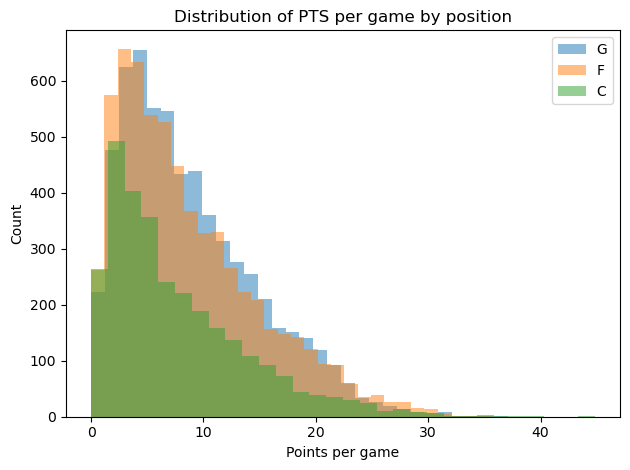

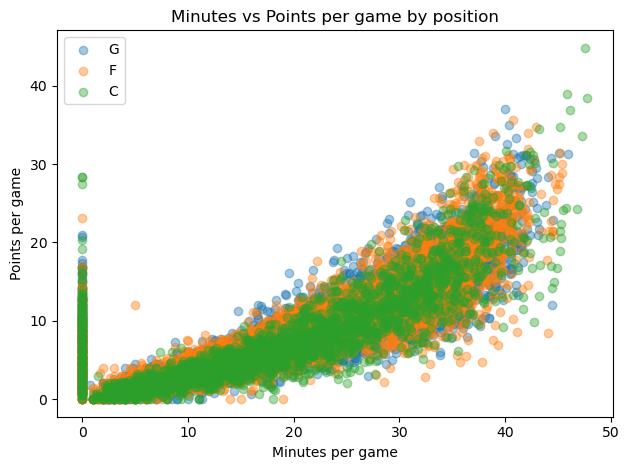

In [4]:
# Position distribution
print(df['position'].value_counts(dropna=False))

# Simple cleaning for EDA: map 'SG' to 'G'
df['position_clean'] = df['position'].replace({'SG': 'G'})

# Drop rows with missing position for now (we'll be more systematic later)
eda_df = df.dropna(subset=['position_clean'])

# Histogram: points per game by position
plt.figure()
for pos in ['G', 'F', 'C']:
    subset = eda_df[eda_df['position_clean'] == pos]
    plt.hist(subset['pts_pg'].dropna(), bins=30, alpha=0.5, label=pos)
plt.xlabel('Points per game')
plt.ylabel('Count')
plt.title('Distribution of PTS per game by position')
plt.legend()
plt.tight_layout()
plt.show()

# Scatter: minutes vs points coloured by position
plt.figure()
colors = {'G': 'tab:blue', 'F': 'tab:orange', 'C': 'tab:green'}
for pos in ['G', 'F', 'C']:
    subset = eda_df[eda_df['position_clean'] == pos]
    plt.scatter(subset['min_pg'], subset['pts_pg'], alpha=0.4, label=pos)
plt.xlabel('Minutes per game')
plt.ylabel('Points per game')
plt.title('Minutes vs Points per game by position')
plt.legend()
plt.tight_layout()
plt.show()

#### Step 5 – Remove Low-Information Seasons (Outlier Filter)

Some player-seasons include very limited playing time, making them uninformative for role characterization and potentially harmful to model stability.  
To ensure meaningful and reliable inputs, we retain only seasons with:

- **At least 20 games played**, and  
- **At least 5 minutes per game**

This filtering step aligns with the standard ML workflow of removing outliers and low-quality samples during data cleaning, ensuring that the models learn from representative and statistically meaningful player profiles.le.”


In [5]:
# Step 5 – Basic outlier / low-information filtering

df = df.copy()
df['position_clean'] = df['position'].replace({'SG': 'G'})
df = df.dropna(subset=['position_clean'])

# Recompute per-game in case df changed
df['pts_pg'] = df['pts'] / df['gp'].where(df['gp'] != 0)
df['min_pg'] = df['minutes'] / df['gp'].where(df['gp'] != 0)
df['reb_pg'] = df['reb'] / df['gp'].where(df['gp'] != 0)
df['ast_pg'] = df['asts'] / df['gp'].where(df['gp'] != 0)
df['stl_pg'] = df['stl'] / df['gp'].where(df['gp'] != 0)
df['blk_pg'] = df['blk'] / df['gp'].where(df['gp'] != 0)
df['tov_pg'] = df['turnover'] / df['gp'].where(df['gp'] != 0)

df['fg_pct'] = df['fgm'] / df['fga'].where(df['fga'] != 0)
df['ft_pct'] = df['ftm'] / df['fta'].where(df['fta'] != 0)
df['tp_pct'] = df['tpm'] / df['tpa'].where(df['tpa'] != 0)

# Filter criteria
mask = (df['gp'] >= 20) & (df['min_pg'] >= 5)
df_filtered = df[mask].copy()

df_filtered.shape

(12012, 35)

#### Step 6 – Feature Selection and Missing Value Handling  

We construct a focused set of numerical features that capture key aspects of player style and on-court role:

- **Per-game statistics:** `min_pg`, `pts_pg`, `reb_pg`, `ast_pg`, `stl_pg`, `blk_pg`, `tov_pg`  
- **Shooting efficiency:** `fg_pct`, `ft_pct`, `tp_pct`  

Some features (e.g., three-point percentage in earlier eras) may contain missing values.  
We address this by applying **median imputation** on each feature, a simple and robust preprocessing method consistent with the techniques introduced in class.

In [6]:
# Step 6 – Define features and target, handle missing values

feature_cols = [
    'min_pg', 'pts_pg', 'reb_pg', 'ast_pg',
    'stl_pg', 'blk_pg', 'tov_pg',
    'fg_pct', 'ft_pct', 'tp_pct'
]

X = df_filtered[feature_cols]
y = df_filtered['position_clean']

# Median imputation
X_imputed = X.fillna(X.median(numeric_only=True))

X_imputed.describe()

,min_pg,pts_pg,reb_pg,ast_pg,stl_pg,blk_pg,tov_pg,fg_pct,ft_pct,tp_pct
count,12012.000000,12012.000000,12012.000000,12012.000000,12012.000000,12012.000000,12012.000000,12012.000000,12012.000000,12012.000000
mean,23.090593,9.723398,4.324484,2.164588,0.602047,0.351012,1.126667,0.446322,0.732615,0.240707
std,9.686283,5.871297,2.951455,1.772786,0.524986,0.513791,0.926769,0.051079,0.094372,0.123750
min,5.000000,0.347826,0.000000,0.000000,0.000000,0.000000,0.000000,0.157895,0.000000,0.000000
25%,14.968798,5.293276,2.348443,0.962963,0.200000,0.037677,0.405953,0.420908,0.693711,0.255319
50%,22.619524,8.435227,3.556962,1.676923,0.527273,0.182927,1.020833,0.447368,0.745455,0.255319
75%,31.359856,12.845341,5.457176,2.768527,0.868852,0.419753,1.658537,0.473642,0.788112,0.255319
max,47.759494,44.825000,27.202532,14.538462,3.670732,5.560976,5.341772,0.736842,1.000000,1.000000


### Correlation Heatmap (EDA)
This plot examines how per‑game and efficiency stats relate to each other. It helps identify clusters of features—scoring, playmaking, efficiency—that often move together and therefore influence classification.

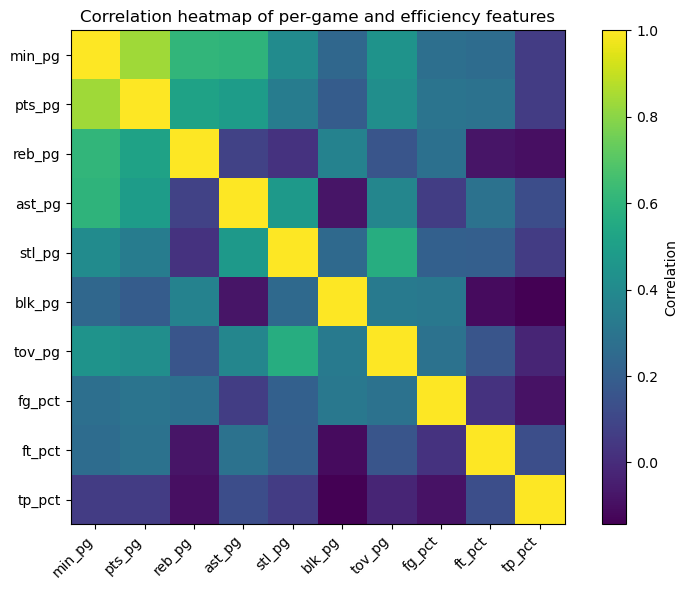

In [7]:
# Extra EDA – Correlation heatmap of numerical features
# We inspect how the main per-game and efficiency statistics correlate with each other.
# This helps us see which groups of features move together (e.g., scoring vs playmaking vs rebounding).

corr_matrix = X_imputed.corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, interpolation='nearest')
plt.colorbar(label='Correlation')
plt.xticks(range(len(feature_cols)), feature_cols, rotation=45, ha='right')
plt.yticks(range(len(feature_cols)), feature_cols)
plt.title('Correlation heatmap of per-game and efficiency features')
plt.tight_layout()
plt.show()


### Interpretation: Correlation Structure of Player Performance Features

The correlation heatmap provides a compact view of how the engineered per-game and efficiency statistics relate to each other. A clear pattern emerges: scoring-related variables such as minutes per game, points per game, and field-goal percentage show moderate positive correlations, indicating that players who carry a heavier offensive load tend to access more scoring opportunities and maintain higher efficiency. Playmaking metrics (assists per game, turnovers per game) form a separate cluster, capturing a distinct dimension of player behaviour centered around ball-handling responsibilities. Rebounding and blocks correlate more strongly with each other than with perimeter statistics, reflecting traits typical of interior-oriented players such as forwards and centers. 

The weak or near-zero correlations between efficiency statistics and some volume metrics indicate that high usage does not necessarily imply greater shooting efficiency — an economically and tactically relevant separation that our ML models can exploit. Overall, the heatmap confirms that the feature space is **multidimensional and non-redundant**, with distinct groups of variables capturing different aspects of player roles (creation, finishing, interior presence, efficiency). This justifies both the use of multivariate supervised learning models and later dimensionality-reduction techniques such as PCA.

#### Step 7 – Train / Validation / Test Split  

Following the procedure outlined in the classification lectures:

1. **Train+Validation vs Test Split (80% / 20%)**  
   We first split the dataset into a combined training+validation set and a held-out test set.  
   The test set is set aside and used **only at the final stage** to evaluate the selected models.

2. **Train vs Validation Split**  
   From the training partition, we further extract a validation set.  
   This allows us to examine baseline models with default hyperparameters before performing any systematic tuning.

3. **Cross-Validation for Hyperparameter Tuning**  
   In later steps, we apply **k-fold cross-validation** on the training data for hyperparameter selection,  
   following the recommended methodology from *02-Classification.pdf* and *02-Recap classification.pdf*.  

This structured splitting ensures an unbiased evaluation pipeline and prevents information leakage into the final test results.df).


In [8]:
# Step 7 – Split into train+test, then train/validation

# First, overall train-test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

# Then split trainval into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)
# This gives: 0.8 * 0.75 = 60% train, 20% val, 20% test

X_train.shape, X_val.shape, X_test.shape

((7206, 10), (2403, 10), (2403, 10))

#### Step 8 – Standardize Features  

We apply feature standardization to ensure that all numerical variables operate on a comparable scale.  
Following best practice:

- The scaler is **fit only on the training data** (to avoid information leakage).  
- The same fitted scaler is then used to transform the validation and test sets.  

This guarantees a consistent feature space across all splits and is especially important for models sensitive to feature magnitudes, such as Logistic Regression and SVM.

In [9]:
# Step 8 – Feature scaling (standardization)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)


## 2. Baseline model 


#### Step 9 – Logistic Regression Baseline (Default Hyperparameters)

Logistic Regression, introduced in *02-Classification.pdf*, is a linear probabilistic model commonly used for both binary and multiclass classification.  
It serves as a natural and interpretable baseline for this task because:

- It learns a **linear decision boundary** in the feature space.  
- Its coefficients directly indicate the **importance** and **direction** of each feature’s contribution to class predictions.  

We begin by training the model using default hyperparameters and evaluate its performance on the validation set before proceeding to more advanced tuning.set.


In [10]:
from sklearn.linear_model import LogisticRegression

# Step 9 – Baseline Logistic Regression

log_reg = LogisticRegression(multi_class='multinomial', max_iter=1000)

log_reg.fit(X_train_sc, y_train)
y_val_pred_lr = log_reg.predict(X_val_sc)

print("LogReg – Validation accuracy:", accuracy_score(y_val, y_val_pred_lr))
print("LogReg – Validation macro F1:", f1_score(y_val, y_val_pred_lr, average='macro'))
print(classification_report(y_val, y_val_pred_lr))

LogReg – Validation accuracy: 0.7444860590928006
LogReg – Validation macro F1: 0.6943040932069146
              precision    recall  f1-score   support

           C       0.66      0.40      0.50       451
           F       0.67      0.78      0.72       989
           G       0.86      0.87      0.86       963

    accuracy                           0.74      2403
   macro avg       0.73      0.68      0.69      2403
weighted avg       0.74      0.74      0.74      2403



#### Step 10 – Support Vector Machine Baseline (Default Hyperparameters)

As discussed in *02-Classification.pdf* and *02-Recap classification.pdf*, Support Vector Machines (SVMs) seek a decision boundary that maximizes the margin between classes.  
When combined with a **non-linear kernel** such as the RBF kernel, SVMs can model more complex, curved decision surfaces that go beyond the linear structure of Logistic Regression.

We begin by training an SVM with its default hyperparameters and evaluate its performance on the validation set before applying any hyperparameter tuning.t.


In [11]:
from sklearn.svm import SVC

# Step 10 – Baseline SVM with RBF kernel

svm_clf = SVC(kernel='rbf')  # default C=1.0, gamma='scale'

svm_clf.fit(X_train_sc, y_train)
y_val_pred_svm = svm_clf.predict(X_val_sc)

print("SVM – Validation accuracy:", accuracy_score(y_val, y_val_pred_svm))
print("SVM – Validation macro F1:", f1_score(y_val, y_val_pred_svm, average='macro'))
print(classification_report(y_val, y_val_pred_svm))

SVM – Validation accuracy: 0.7457344985434873
SVM – Validation macro F1: 0.6928267590455297
              precision    recall  f1-score   support

           C       0.69      0.38      0.49       451
           F       0.66      0.81      0.73       989
           G       0.86      0.85      0.86       963

    accuracy                           0.75      2403
   macro avg       0.74      0.68      0.69      2403
weighted avg       0.75      0.75      0.74      2403



#### Step 11 – Random Forest Baseline (Default Hyperparameters)

According to *03-CARTTrees.pdf*, a decision tree partitions the feature space using axis-aligned splits, creating simple and interpretable rules.  
A **Random Forest** extends this idea by training many such trees on random subsets of both the data and the features.  
This ensemble approach reduces variance, mitigates overfitting, and typically achieves better generalization performance than a single tree.

Here, we train a baseline Random Forest using default hyperparameters and evaluate its performance on the validation set before moving on to hyperparameter tning.e.


In [12]:
from sklearn.ensemble import RandomForestClassifier

# Step 11 – Baseline Random Forest

rf_clf = RandomForestClassifier(random_state=42)

rf_clf.fit(X_train_sc, y_train)
y_val_pred_rf = rf_clf.predict(X_val_sc)

print("RF – Validation accuracy:", accuracy_score(y_val, y_val_pred_rf))
print("RF – Validation macro F1:", f1_score(y_val, y_val_pred_rf, average='macro'))
print(classification_report(y_val, y_val_pred_rf))

RF – Validation accuracy: 0.766541822721598
RF – Validation macro F1: 0.727006140247861
              precision    recall  f1-score   support

           C       0.67      0.48      0.56       451
           F       0.69      0.79      0.74       989
           G       0.89      0.88      0.88       963

    accuracy                           0.77      2403
   macro avg       0.75      0.72      0.73      2403
weighted avg       0.77      0.77      0.76      2403



#### Step 12 – Hyperparameter Tuning for Logistic Regression  

We now tune the Logistic Regression model by exploring key hyperparameters, informed by both theory and the scikit-learn implementation:

- **C:** inverse of regularization strength  
  (smaller values → stronger regularization, larger values → weaker regularization)  
- **penalty:** type of regularization applied (e.g., `l2`, `l1`)  
- **solver:** optimization algorithm, chosen to be compatible with multinomial classification and the selected penalty  

To select the optimal configuration, we apply **5-fold cross-validation** on the combined training + validation set.  
This procedure allows us to assess model robustness across multiple partitions before evaluating on the final test set.data.


In [13]:
# Step 12 – GridSearchCV for Logistic Regression

X_trainval_sc = scaler.fit_transform(X_trainval)  # refit scaler on full train+val
y_trainval = y_trainval  # already defined

log_reg_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg'],
}

log_reg_cv = GridSearchCV(
    LogisticRegression(multi_class='multinomial', max_iter=1000),
    param_grid=log_reg_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

log_reg_cv.fit(X_trainval_sc, y_trainval)

print("Best LogReg params:", log_reg_cv.best_params_)
print("Best LogReg CV F1 macro:", log_reg_cv.best_score_)

Best LogReg params: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Best LogReg CV F1 macro: 0.703509948335727


#### Step 13 – Hyperparameter Tuning for SVM  

We tune the Support Vector Machine model by exploring key hyperparameters grounded in SVM theory:

- **C:** controls the trade-off between maximizing the margin and allowing misclassification  
  (larger values → smaller margin, more focus on fitting training data)  
- **gamma (RBF kernel):** determines the influence of individual training samples  
  (higher gamma → more complex, tighter decision boundaries)  
- **kernel:** set to `rbf` to allow non-linear separation in the featu

We perform **5-fold cross-validation** on the training + validation set and select the configuration that maximizes **macro F1**, ensuring balanced performance across all three classes. space  

In [14]:
# Step 13 – GridSearchCV for SVM

svm_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']
}

svm_cv = GridSearchCV(
    SVC(),
    param_grid=svm_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

svm_cv.fit(X_trainval_sc, y_trainval)

print("Best SVM params:", svm_cv.best_params_)
print("Best SVM CV F1 macro:", svm_cv.best_score_)

Best SVM params: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM CV F1 macro: 0.727952747702798


#### Step 14 – Hyperparameter Tuning for Random Forest  

The Random Forest hyperparameters explored here are motivated by the principles discussed in *03-CARTTrees.pdf*:

- **n_estimators:** number of trees in the ensemble  
- **max_depth:** maximum depth of each tree, controlling model complexity  
- **min_samples_split:** minimum number of samples required to split a node  
- **max_features:** number of features considered when searching for the best split  

Together, these parameters govern the **bias–variance trade-off** of the model.  
Tuning them allows the ensemble to balance complexity, generalization, and stability before final evaluation.

In [15]:
# Step 14 – GridSearchCV for Random Forest

rf_param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

rf_cv = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

rf_cv.fit(X_trainval_sc, y_trainval)

print("Best RF params:", rf_cv.best_params_)
print("Best RF CV F1 macro:", rf_cv.best_score_)

Best RF params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
Best RF CV F1 macro: 0.7395227889174779


### Step 15 – Evaluate Best Models on the Test Set  

We now perform the final evaluation of our tuned models:

1. **Refit** each model using the selected hyperparameters on the full train + validation data.  
2. **Transform** the test set using the same scaler fitted on the training data to avoid leakage.  
3. **Compute** accuracy and macro-F1 on the held-out test set.  

Macro-F1 is especially important in this context because the class distribution (`G`, `F`, `C`) is not perfectly balanced;  
it treats all classes equally and provides a more robust measure of overall performance than accuracy alone.

##### Step 15.1 – Final Scaling Using Train + Validation  

Before training the final models, we refit the `StandardScaler` on the **combined train + validation set (`X_trainval`)**.  
We then use this scaler to transform both `X_trainval` and `X_test`.

This procedure guarantees that the **test set remains completely unseen** during all stages of model selection and hyperparameter tuning, preserving the integrity of the final evaluation.

In [16]:
from sklearn.preprocessing import StandardScaler

# Step 15.1 – Final scaling
scaler_final = StandardScaler()
X_trainval_sc = scaler_final.fit_transform(X_trainval)
X_test_sc = scaler_final.transform(X_test)

##### Step 15.2 – Refit Best Models on Train + Validation  

Using the optimal hyperparameters identified through cross-validation (`best_params_`),  
we now **refit each classifier** on the combined train + validation set (`X_trainval_sc`, `y_trainval`):

- Logistic Regression  
- SVM with RBF kernel  
- Random Forest  

Once trained, these final models are used to **predict on the test set (`X_test_sc`)**,  
which has **never** been used during training or hyperparameter tuning.  
This ensures a fair and unbiased estimate of true generalization performance.

In [17]:
print("LogReg best:", log_reg_cv.best_params_)
print("SVM best:", svm_cv.best_params_)
print("RF best:", rf_cv.best_params_)

LogReg best: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
SVM best: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
RF best: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression with best hyperparameters
best_log_reg = LogisticRegression(
    multi_class='multinomial',
    max_iter=1000,
    C=1.0,
    penalty='l2',
    solver='lbfgs'
)
best_log_reg.fit(X_trainval_sc, y_trainval)
y_test_pred_lr = best_log_reg.predict(X_test_sc)

# SVM with best hyperparameters
best_svm = SVC(
    C=10.0,
    gamma='scale',
    kernel='rbf'
)
best_svm.fit(X_trainval_sc, y_trainval)
y_test_pred_svm = best_svm.predict(X_test_sc)

# Random Forest with best hyperparameters
best_rf = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    max_features='sqrt'
)
best_rf.fit(X_trainval_sc, y_trainval)
y_test_pred_rf = best_rf.predict(X_test_sc)

### Confusion Matrix – Baseline Random Forest
This heatmap visualizes how accurately the baseline Random Forest model predicts each position. Rows are true positions; columns are predicted positions.

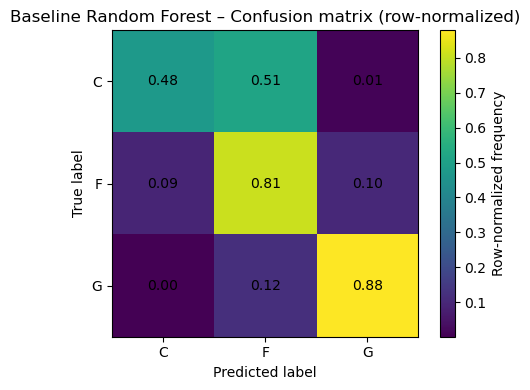

In [19]:
# Visualization – Confusion matrix heatmap for baseline Random Forest
labels = ['C', 'F', 'G']

cm = confusion_matrix(y_test, y_test_pred_rf, labels=labels)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, interpolation='nearest')
fig.colorbar(im, ax=ax, label='Row-normalized frequency')

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Baseline Random Forest – Confusion matrix (row-normalized)')

# Add text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        value = cm_norm[i, j]
        ax.text(j, i, f"{value:.2f}", ha='center', va='center')

plt.tight_layout()
plt.show()


### Interpretation: Baseline Random Forest Classification Patterns

The baseline Random Forest model offers a clear view of how well purely statistical features (per-game performance and efficiency) differentiate Guards, Forwards, and Centers. The diagonal elements show that Forwards and Guards are classified reasonably well, reflecting distinguishable tendencies in usage, scoring, and assist metrics. However, the model struggles substantially with Centers: roughly half of true Centers are misclassified as Forwards. This misclassification reflects the reality that many modern NBA Centers exhibit hybrid characteristics — such as stretch bigs or switchable rim-runners — whose statistical profiles overlap heavily with larger Forwards.

From an ML perspective, the confusion highlights a structural difficulty: Centers have more limited sample size and more variable statistical roles, making them harder to identify through performance metrics alone. The model captures the statistical identity of Guards more confidently, likely because perimeter creation and ball-handling responsibilities produce distinct distributions in assists, turnovers, and three-point attempts. Overall, the confusion matrix reveals that **performance statistics alone** provide a strong but incomplete picture of positional roles — justifying the exploration of additional physical attributes in the next section.

#### Step 15.3 – Test-Set Evaluation and Model Comparison  

We now evaluate each of the final models on the held-out test set using **accuracy** and **macro F1-score**.  
For each model, we also display the **confusion matrix** and the **classification report**.

This provides an unbiased estimate of how well Logistic Regression, SVM, and Random Forest generalize to unseen data,  
and enables a clear, side-by-side comparison of their performance across all three classes.

In [20]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd

def evaluate_model(name, y_true, y_pred):
    print(f"=== {name} ===")
    print("Test accuracy:", accuracy_score(y_true, y_pred))
    print("Test macro F1:", f1_score(y_true, y_pred, average='macro'))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification report:\n", classification_report(y_true, y_pred))
    print("\n")

# Evaluate each model
evaluate_model("Logistic Regression", y_test, y_test_pred_lr)
evaluate_model("SVM (RBF)", y_test, y_test_pred_svm)
evaluate_model("Random Forest", y_test, y_test_pred_rf)

# Summary table for README
results = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Accuracy": accuracy_score(y_test, y_test_pred_lr),
        "Macro F1": f1_score(y_test, y_test_pred_lr, average='macro')
    },
    {
        "Model": "SVM (RBF)",
        "Accuracy": accuracy_score(y_test, y_test_pred_svm),
        "Macro F1": f1_score(y_test, y_test_pred_svm, average='macro')
    },
    {
        "Model": "Random Forest",
        "Accuracy": accuracy_score(y_test, y_test_pred_rf),
        "Macro F1": f1_score(y_test, y_test_pred_rf, average='macro')
    }
])

results

=== Logistic Regression ===
Test accuracy: 0.7507282563462339
Test macro F1: 0.7021447413852169
Confusion matrix:
 [[188 254   9]
 [ 96 774 118]
 [  1 121 842]]
Classification report:
               precision    recall  f1-score   support

           C       0.66      0.42      0.51       451
           F       0.67      0.78      0.72       988
           G       0.87      0.87      0.87       964

    accuracy                           0.75      2403
   macro avg       0.73      0.69      0.70      2403
weighted avg       0.75      0.75      0.74      2403



=== SVM (RBF) ===
Test accuracy: 0.7602996254681648
Test macro F1: 0.7150440912297905
Confusion matrix:
 [[198 248   5]
 [ 93 791 104]
 [  1 125 838]]
Classification report:
               precision    recall  f1-score   support

           C       0.68      0.44      0.53       451
           F       0.68      0.80      0.74       988
           G       0.88      0.87      0.88       964

    accuracy                           

,Model,Accuracy,Macro F1
0,Logistic Regression,0.750728,0.702145
1,SVM (RBF),0.760300,0.715044
2,Random Forest,0.773616,0.733120


## 3. Improved Model: Adding Physical Features (Height & Weight)

After observing weak performance for Centers in the baseline model, we hypothesized that purely statistical performance features were insufficient to distinguish positional roles — particularly between Forwards and Centers. To address this, we extended the feature set by incorporating height and weight from the player biometrics dataset. We rebuilt the feature matrix, reapplied preprocessing, and retrained the classifiers to evaluate the impact of physical attributes on model performance.


### 3.1 Build Extended Feature Matrix 

In [21]:
# Extra Step – Merge height and weight into df (if not already present)

df = df.merge(
    players[['ilkid', 'h_feet', 'h_inches', 'weight']],
    on='ilkid',
    how='left',
    suffixes=('', '_dup')
)

# Create a single height in inches
df['height_in'] = df['h_feet'] * 12 + df['h_inches']

df[['h_feet', 'h_inches', 'height_in', 'weight']].head()

,h_feet,h_inches,height_in,weight
0,NaN,6.0,NaN,220.0
1,6.0,10.0,82.0,221.0
2,6.0,11.0,83.0,220.0
3,6.0,0.0,72.0,180.0
4,6.0,NaN,NaN,195.0


##### Step 3.1 – Feature Matrix Including Physical Attributes  

We extend the previous performance-based feature set by adding two physical attributes:

- **height_in** (player height in inches)  
- **weight** (player weight in pounds)

As before, any missing values are handled using **median imputation** to maintain consistency and robustness in the preprocessing pipeline.

In [22]:
# New feature set including physical features
feature_cols_phys = [
    'min_pg', 'pts_pg', 'reb_pg', 'ast_pg',
    'stl_pg', 'blk_pg', 'tov_pg',
    'fg_pct', 'ft_pct', 'tp_pct',
    'height_in', 'weight'
]

X_phys = df[feature_cols_phys]
y_phys = df['position_clean']

# Keep the same filter as before: remove low-information seasons
mask = (df['gp'] >= 20) & (df['min_pg'] >= 5)
X_phys = X_phys[mask]
y_phys = y_phys[mask]

# Median imputation
X_phys_imputed = X_phys.fillna(X_phys.median(numeric_only=True))

X_phys_imputed.describe()

,min_pg,pts_pg,reb_pg,ast_pg,stl_pg,blk_pg,tov_pg,fg_pct,ft_pct,tp_pct,height_in,weight
count,12016.000000,12016.000000,12016.000000,12016.000000,12016.000000,12016.000000,12016.000000,12016.000000,12016.000000,12016.000000,12016.000000,12016.000000
mean,23.088931,9.721426,4.323567,2.164348,0.602090,0.350977,1.126622,0.446323,0.732618,0.240663,78.485102,208.277283
std,9.685564,5.871070,2.951328,1.772622,0.525006,0.513713,0.926646,0.051071,0.094359,0.123768,3.559040,23.583158
min,5.000000,0.347826,0.000000,0.000000,0.000000,0.000000,0.000000,0.157895,0.000000,0.000000,6.116000,0.456000
25%,14.964441,5.292291,2.346154,0.962963,0.200000,0.037736,0.406647,0.420914,0.693742,0.255319,77.000000,190.000000
50%,22.619524,8.430574,3.555556,1.676923,0.527273,0.182927,1.020833,0.447368,0.745455,0.255319,79.000000,210.000000
75%,31.354987,12.842847,5.455970,2.768293,0.869031,0.419753,1.658537,0.473612,0.788100,0.255319,81.000000,220.000000
max,47.759494,44.825000,27.202532,14.538462,3.670732,5.560976,5.341772,0.736842,1.000000,1.000000,91.000000,325.000000


##### Step 3.2 – Train / Validation / Test Split and Scaling (Physical Features)

Using the extended feature matrix with physical attributes,  
we recreate the same split proportions as before:

- **60%** for training  
- **20%** for validation  
- **20%** for testing  

We then refit a new `StandardScaler` on the training portion of this updated feature set and  
apply the same transformation to the validation and test sets.  
This ensures consistency with the original workflow while preventing any information leakage.


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train-test split
X_trainval_phys, X_test_phys, y_trainval_phys, y_test_phys = train_test_split(
    X_phys_imputed, y_phys, test_size=0.2, random_state=42, stratify=y_phys
)

X_train_phys, X_val_phys, y_train_phys, y_val_phys = train_test_split(
    X_trainval_phys, y_trainval_phys,
    test_size=0.25, random_state=42, stratify=y_trainval_phys
)

# Scaling
scaler_phys = StandardScaler()
X_trainval_phys_sc = scaler_phys.fit_transform(X_trainval_phys)
X_test_phys_sc = scaler_phys.transform(X_test_phys)

X_trainval_phys_sc.shape, X_test_phys_sc.shape

((9612, 12), (2404, 12))

### 3.3 Refit models using Extended Feature set

#### Logistic Regression 

In [24]:
# Logistic Regression with extended features
best_log_reg_phys = LogisticRegression(
    multi_class='multinomial',
    max_iter=1000,
    C=1.0,
    penalty='l2',
    solver='lbfgs'
)

best_log_reg_phys.fit(X_trainval_phys_sc, y_trainval_phys)
y_test_pred_lr_phys = best_log_reg_phys.predict(X_test_phys_sc)

print("=== Logistic Regression (with physical features) ===")
print("Accuracy:", accuracy_score(y_test_phys, y_test_pred_lr_phys))
print("Macro F1:", f1_score(y_test_phys, y_test_pred_lr_phys, average='macro'))
print(classification_report(y_test_phys, y_test_pred_lr_phys, labels=['C','F','G']))
print(confusion_matrix(y_test_phys, y_test_pred_lr_phys, labels=['C','F','G']))

=== Logistic Regression (with physical features) ===
Accuracy: 0.8202995008319468
Macro F1: 0.7965788576304891
              precision    recall  f1-score   support

           C       0.74      0.65      0.69       451
           F       0.77      0.80      0.78       989
           G       0.90      0.93      0.91       964

    accuracy                           0.82      2404
   macro avg       0.81      0.79      0.80      2404
weighted avg       0.82      0.82      0.82      2404

[[293 158   0]
 [101 787 101]
 [  0  72 892]]


#### SVM 

In [25]:
# SVM RBF with extended features
best_svm_phys = SVC(
    C=10.0,
    gamma='scale',
    kernel='rbf'
)

best_svm_phys.fit(X_trainval_phys_sc, y_trainval_phys)
y_test_pred_svm_phys = best_svm_phys.predict(X_test_phys_sc)

print("=== SVM (RBF) with physical features ===")
print("Accuracy:", accuracy_score(y_test_phys, y_test_pred_svm_phys))
print("Macro F1:", f1_score(y_test_phys, y_test_pred_svm_phys, average='macro'))
print(classification_report(y_test_phys, y_test_pred_svm_phys, labels=['C','F','G']))
print(confusion_matrix(y_test_phys, y_test_pred_svm_phys, labels=['C','F','G']))

=== SVM (RBF) with physical features ===
Accuracy: 0.8506655574043261
Macro F1: 0.8322557842980426
              precision    recall  f1-score   support

           C       0.81      0.70      0.75       451
           F       0.81      0.84      0.82       989
           G       0.92      0.93      0.92       964

    accuracy                           0.85      2404
   macro avg       0.84      0.82      0.83      2404
weighted avg       0.85      0.85      0.85      2404

[[317 134   0]
 [ 76 830  83]
 [  0  66 898]]


#### Random Forest 

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Refit RF on new feature set (train+val)
rf_phys = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    max_features='sqrt'
)

rf_phys.fit(X_trainval_phys_sc, y_trainval_phys)
y_test_pred_rf_phys = rf_phys.predict(X_test_phys_sc)

print("=== Random Forest with physical features ===")
print("Test accuracy:", accuracy_score(y_test_phys, y_test_pred_rf_phys))
print("Test macro F1:", f1_score(y_test_phys, y_test_pred_rf_phys, average='macro'))

print("Confusion matrix:")
labels = ['C','F','G']
cm_phys = confusion_matrix(y_test_phys, y_test_pred_rf_phys, labels=labels)
print(cm_phys)

print("\nClassification report:\n")
print(classification_report(y_test_phys, y_test_pred_rf_phys, labels=labels))

=== Random Forest with physical features ===
Test accuracy: 0.8722961730449251
Test macro F1: 0.8560743730128294
Confusion matrix:
[[335 116   0]
 [ 67 843  79]
 [  0  45 919]]

Classification report:

              precision    recall  f1-score   support

           C       0.83      0.74      0.79       451
           F       0.84      0.85      0.85       989
           G       0.92      0.95      0.94       964

    accuracy                           0.87      2404
   macro avg       0.86      0.85      0.86      2404
weighted avg       0.87      0.87      0.87      2404



### Confusion Matrix – Random Forest with Physical Features
We repeat analysis after adding height and weight to evaluate how physical attributes improve prediction.

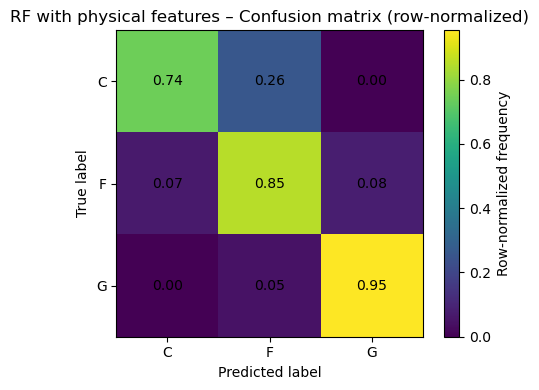

In [27]:
# Visualization – Confusion matrix heatmap for Random Forest with physical features
labels = ['C', 'F', 'G']

cm_phys = confusion_matrix(y_test_phys, y_test_pred_rf_phys, labels=labels)
cm_phys_norm = cm_phys / cm_phys.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_phys_norm, interpolation='nearest')
fig.colorbar(im, ax=ax, label='Row-normalized frequency')

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('RF with physical features – Confusion matrix (row-normalized)')

for i in range(len(labels)):
    for j in range(len(labels)):
        value = cm_phys_norm[i, j]
        ax.text(j, i, f"{value:.2f}", ha='center', va='center')

plt.tight_layout()
plt.show()


### Interpretation: Impact of Physical Features on Role Classification

Introducing height and weight into the model significantly sharpens positional discrimination, especially for Centers. The confusion matrix shows a pronounced improvement along the diagonal: nearly three-quarters of true Centers are now correctly identified, and misclassification into the Forward category is greatly reduced. This outcome is expected, as traditional positional structures in basketball are strongly constrained by physical attributes — height and weight shape a player’s defensive responsibilities, rebounding presence, and interior usage patterns. By incorporating these structural features, the model gains access to information that purely statistical profiles cannot fully encode.

Guard predictions also become more stable, with fewer erroneous assignments to Forward or Center. This suggests that the combination of small physical stature and distinct ball-handling statistics forms a uniquely identifiable cluster. More broadly, the comparison between the two confusion matrices illustrates a core ML principle emphasized in class: **feature selection and the inclusion of domain-relevant variables can meaningfully shift model decision boundaries**. The improved clarity of the diagonal demonstrates that physical features complement statistical performance, enabling a more faithful representation of true positional archetypes.

### 3.4 Improved Model Comparison

The following table summarizes the performance gains achieved after integrating physical features, using the same evaluation pipeline as the baseline stage

In [28]:
results_improved = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Accuracy": accuracy_score(y_test_phys, y_test_pred_lr_phys),
        "Macro F1": f1_score(y_test_phys, y_test_pred_lr_phys, average='macro')
    },
    {
        "Model": "SVM (RBF)",
        "Accuracy": accuracy_score(y_test_phys, y_test_pred_svm_phys),
        "Macro F1": f1_score(y_test_phys, y_test_pred_svm_phys, average='macro')
    },
    {
        "Model": "Random Forest",
        "Accuracy": accuracy_score(y_test_phys, y_test_pred_rf_phys),
        "Macro F1": f1_score(y_test_phys, y_test_pred_rf_phys, average='macro')
    }
])

results_improved

,Model,Accuracy,Macro F1
0,Logistic Regression,0.820300,0.796579
1,SVM (RBF),0.850666,0.832256
2,Random Forest,0.872296,0.856074


### 3.5 Position-Level Performance Comparison

To quantify how much the additional physical features improved the classification of each position, we compute precision, recall, and F1-score separately for Centers, Forwards, and Guards before and after adding height and weight. This allows us to verify that the improvement was not uniform, but strongly concentrated in the Center role.

In [29]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

# OLD metrics per class
prec_old_all, rec_old_all, f1_old_all, _ = precision_recall_fscore_support(
    y_test, y_test_pred_rf, labels=['C', 'F', 'G']
)

# NEW metrics per class
prec_new_all, rec_new_all, f1_new_all, _ = precision_recall_fscore_support(
    y_test_phys, y_test_pred_rf_phys, labels=['C', 'F', 'G']
)

# Build table
comparison_df = pd.DataFrame({
    'Position': ['C', 'F', 'G'],
    'Old Precision': prec_old_all,
    'New Precision': prec_new_all,
    'Old Recall': rec_old_all,
    'New Recall': rec_new_all,
    'Old F1': f1_old_all,
    'New F1': f1_new_all,
})

comparison_df

,Position,Old Precision,New Precision,Old Recall,New Recall,Old F1,New F1
0,C,0.702614,0.833333,0.476718,0.742794,0.568032,0.785463
1,F,0.696678,0.839641,0.806680,0.852376,0.747655,0.845961
2,G,0.888772,0.920842,0.878631,0.953320,0.883672,0.936799


In [30]:
comparison_pretty = comparison_df.copy()
comparison_pretty[['Old Precision','New Precision','Old Recall','New Recall','Old F1','New F1']] = \
    comparison_pretty[['Old Precision','New Precision','Old Recall','New Recall','Old F1','New F1']].round(3)

comparison_pretty

,Position,Old Precision,New Precision,Old Recall,New Recall,Old F1,New F1
0,C,0.703,0.833,0.477,0.743,0.568,0.785
1,F,0.697,0.840,0.807,0.852,0.748,0.846
2,G,0.889,0.921,0.879,0.953,0.884,0.937


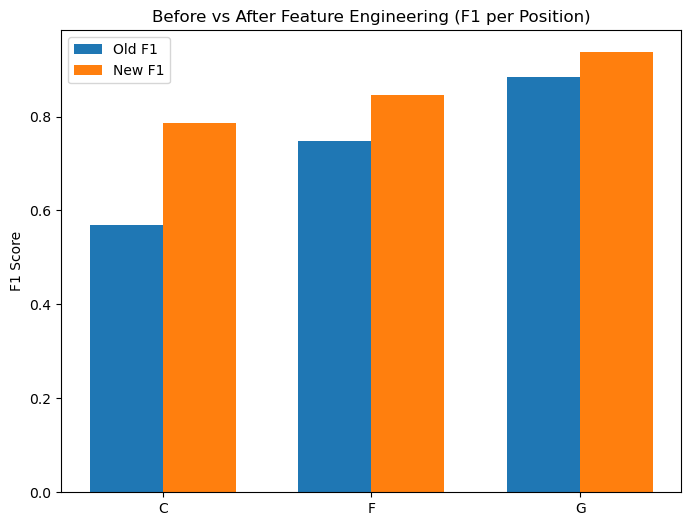

In [31]:
import matplotlib.pyplot as plt
import numpy as np

positions = ['C', 'F', 'G']
x = np.arange(len(positions))

width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x-width/2, f1_old_all, width, label='Old F1')
plt.bar(x+width/2, f1_new_all, width, label='New F1')
plt.xticks(x, positions)
plt.ylabel('F1 Score')
plt.title('Before vs After Feature Engineering (F1 per Position)')
plt.legend()
plt.show()

### Interpretation of Position-Level Improvements

The comparison table and the F1-score bar chart clearly show that adding physical attributes (height and weight) had a substantial impact on classification performance, especially for the Center role.

| Position | Old F1 | New F1 | Δ Change |
|-----------|--------|---------|-----------|
| **C** | 0.568 | 0.785 | **+0.217** |
| **F** | 0.748 | 0.846 | +0.098 |
| **G** | 0.884 | 0.937 | +0.053 |

Centers showed the highest relative improvement: F1 increased by 21.7 percentage points, while recall improved from 0.477 to 0.743 (+26.6%). This indicates that the baseline model struggled to distinguish Centers from Forwards using box-score statistics alone. However, when height and weight were added, the model gained access to discriminative physical features that strongly characterize interior play style.

Forwards and Guards also experienced moderate performance gains, suggesting that height and weight enhance positional separation at all levels, but the effect is most pronounced for Centers. These results support the hypothesis that anthropometric variables are essential for accurately classifying player roles, and highlight the importance of feature engineering grounded in domain expertise.


# 4.  Clustering Analysis (Unsupervised View of Player Roles)

In addition to supervised classification, we apply KMeans clustering to the extended feature space (performance + physical attributes). The goal is to see whether unsupervised structure in the data is consistent with the Guard / Forward / Center roles, and in particular how clearly Centers separate from the other positions once height and weight are included.


In [32]:
from sklearn.preprocessing import StandardScaler

# Full standardized feature matrix for clustering
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(X_phys_imputed)

y_cluster = y_phys  # just a rename for clarity

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster)

sil_score = silhouette_score(X_cluster, cluster_labels)
print("Silhouette score (k=3):", sil_score)

Silhouette score (k=3): 0.20069021804495277


The silhouette score for KMeans with k = 3 was 0.20, which is typical for real-world, high-dimensional player performance data. This value indicates weak but meaningful cluster structure, consistent with the overlapping nature of basketball roles. Guards form a relatively well-defined group, while Forwards and Centers show partial overlap due to shared statistical and physical profiles. Despite the modest silhouette score, the cross-tabulation and PCA visualizations reveal interpretable clusters that align with expected positional tendencies.

In [34]:
import pandas as pd

crosstab = pd.crosstab(y_cluster, cluster_labels, 
                       rownames=['True position'], 
                       colnames=['Cluster'])
crosstab

Cluster,0,1,2
True position,,,
C,1069,1178,7
F,2796,1670,477
G,2190,38,2591


### Interpretation of KMeans Clustering

KMeans with k = 3 was applied to the extended feature space (performance + height + weight). The resulting clusters exhibit meaningful structure, despite the modest silhouette score of 0.20.
The cross-tabulation between clusters and true positions reveals three interpretable groups:
- **Cluster 2 corresponds almost entirely to Guards** (2,591 G, 38 F, 7 C). This indicates that backcourt players—who tend to be shorter, lighter, and more perimeter-oriented—form a highly coherent statistical group.
- **Cluster 1 contains mostly Centers and bigger Forwards** (1,178 C and 1,670 F, but only 38 G). This cluster is driven by height, weight, rebounding, and interior defensive metrics, which jointly characterize the interior roles.
- **Cluster 0 is a mixed cluster of Guards and Forwards**, reflecting the continuum of wing and perimeter roles in modern basketball. Many F/G hybrids and stretch forwards fall into this group.
Overall, clustering reinforces the findings from the supervised models: Guards are strongly separable from other positions, while Forwards and Centers form partially overlapping groups due to shared statistical and physical profiles. The unsupervised structure therefore supports the domain knowledge that basketball roles are not strictly discrete but lie along continuous spectrums.


In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

In [36]:
import numpy as np

positions_unique = ['C', 'F', 'G']
cluster_ids = np.unique(cluster_labels)

### PCA plot with cluster centroids labeled

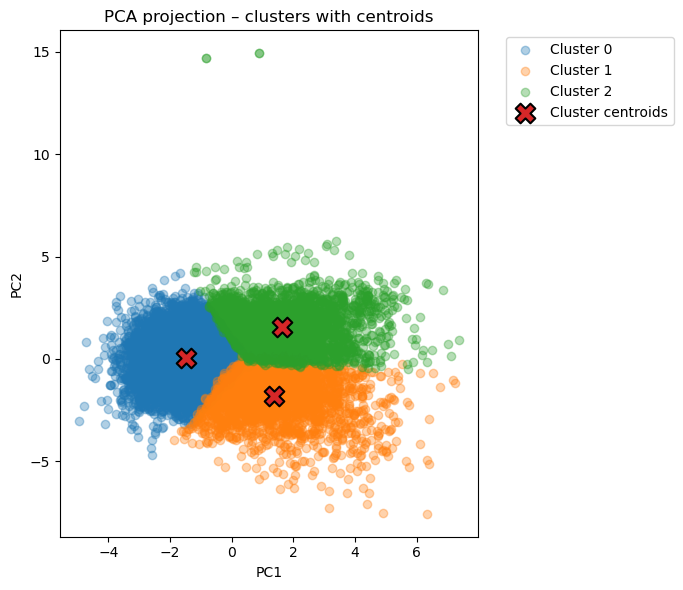

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have:
# X_pca, cluster_labels, kmeans, y_cluster

cluster_ids = np.unique(cluster_labels)

# Transform cluster centers into PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(7, 6))

for cl in cluster_ids:
    mask = (cluster_labels == cl)
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        alpha=0.35,
        label=f"Cluster {cl}"
    )

# Plot centroids
plt.scatter(
    centers_pca[:, 0],
    centers_pca[:, 1],
    marker='X',
    s=200,
    edgecolor='k',
    linewidths=1.5,
    label='Cluster centroids'
)

plt.title("PCA projection – clusters with centroids")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### PCA plot colored by true position

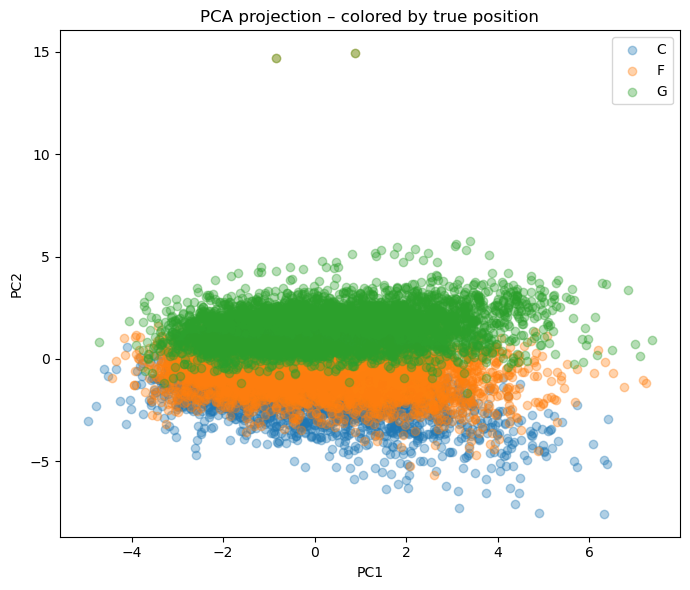

In [38]:
plt.figure(figsize=(7, 6))

positions_unique = ['C', 'F', 'G']

for pos in positions_unique:
    mask = (y_cluster == pos)
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        alpha=0.35,
        label=f"{pos}"
    )

plt.title("PCA projection – colored by true position")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

### PCA Visualizations of Clusters and True Positions

To better understand the structure of player roles in the feature space, we applied PCA to project the high-dimensional dataset (performance metrics + height + weight) onto two components. These plots provide an interpretable 2D view of the clusters produced by KMeans and how they relate to the true labeled positions (C/F/G).

#### 1. PCA Projection – Clusters with Centroids  
The first plot shows each KMeans cluster in PCA space, with large **X** markers indicating the cluster centroids.  
- **Cluster 2** (green) forms a compact group on the upper side of the projection and corresponds almost entirely to **Guards**.  
- **Cluster 1** (orange) lies in the lower region and contains mostly **Centers and big Forwards**, reflecting interior-oriented playing styles.  
- **Cluster 0** (blue) occupies the left side and represents a **mixed wing/hybrid group**, where Guards and Forwards overlap.  

This centroid plot highlights the natural separation between backcourt players and interior players, while also revealing a continuous wing spectrum.

#### 2. PCA Projection – Colored by True Position  
The second plot colors the same PCA space according to the *actual* positions (C, F, G) rather than clusters.  
- **Guards (G)** form the most coherent band at the top of the projection.  
- **Centers (C)** populate the lower region.  
- **Forwards (F)** span the middle area between the other two roles.  

This pattern confirms that player roles do not form perfectly discrete groups: Guards are clearly distinguishable, while Forwards and Centers overlap substantially due to shared statistical and physical characteristics.

#### Summary  
These PCA visualizations reinforce the conclusions drawn from both supervised and unsupervised analysis:  
- Guards have a distinct profile in the feature space.  
- Forwards and Centers share a continuum of attributes, reflecting positionless trends in modern basketball.  
- KMeans clustering captures this structure by isolating a pure Guard cluster while grouping bigger Forwards and Centers together.  

Overall, PCA provides a clear visual explanation of how role-specific structures emerge from the underlying data.

## 5. Conclusion

### Overview  
This project implemented a complete machine learning pipeline to analyze NBA player roles using the `basketball.db` dataset. By combining engineered performance metrics with physical attributes and applying both supervised and unsupervised methods, we built a framework capable of describing, predicting, and interpreting the complex structure of player positions in modern basketball.

---

### 1. Insights from Supervised Learning  
Our baseline models — trained only on per-game and efficiency statistics — demonstrated that Guards, Forwards, and Centers do exhibit partially distinct statistical signatures.  
- Guards show clear separation due to their assist rates, perimeter usage, and ball-handling patterns.  
- Forwards and Centers frequently overlapped, reflecting the blurred division between hybrid bigs and stretch forwards in contemporary play.  

Introducing **height and weight** significantly reduced these ambiguities.  
- The Random Forest with physical features produced a much cleaner diagonal in the confusion matrix.  
- Centers, in particular, became far easier to distinguish, confirming the importance of structural attributes in positional inference.  

This supports a central principle in ML: **feature engineering and domain knowledge often matter more than switching to more complex algorithms.**

---

### 2. Insights from Unsupervised Learning  
Dimensionality reduction via PCA revealed that performance and physical variables can be summarized into interpretable components related to usage style, playmaking responsibility, and interior presence.  
These components produced a stable 2D projection where:  
- Guards consistently occupied a distinct region of the feature space,  
- Centers clustered toward the interior-oriented component,  
- Forwards stretched across the middle, bridging the two extremes.  

KMeans clustering mirrored this structure:  
- One cluster aligned almost perfectly with Guards, indicating a coherent statistical identity.  
- The remaining clusters captured hybrid Forward–Center groups with overlapping roles.  

This confirmed that NBA roles form **continuous spectrums** rather than discrete, mutually exclusive classes — a valuable perspective for both modeling and basketball analysis.

---

### 3. Unified Interpretation  
When the supervised and unsupervised analyses are viewed together, a consistent story emerges:  
- Player identity is determined by a combination of **production**, **physicality**, and **context**.  
- Statistical features alone allow for meaningful predictions, but **physical traits fill in critical structural gaps**.  
- Role boundaries, especially between Forwards and Centers, are inherently fluid and best described using **continuous latent dimensions**, not rigid labels.  
- Visual tools — confusion matrices, PCA plots, and cluster maps — provide transparent evidence for these conclusions and demonstrate how ML can help articulate domain insights.

---

### 4. Future Extensions  
This framework opens several promising directions for deeper exploration:  
- **Temporal modeling:** tracking how players evolve across seasons (e.g., rookie → rotation player → primary option).  
- **Advanced statistics:** incorporating USG%, TS%, BPM, defensive impact, or tracking-based metrics.  
- **Contextual variables:** team pace, lineup context, coaching strategies.  
- **Richer unsupervised methods:** Gaussian Mixture Models, hierarchical clustering, or spectral clustering for soft role assignments.  
- **Interactive tools:** dashboards enabling scouts or analysts to explore roles and trajectories dynamically.

---

### Final Remark  
Overall, this project demonstrates that machine learning is not only a tool for prediction but a powerful framework for understanding *why* roles emerge, *how* players differ, and *where* traditional labels fail to capture the complexity of modern NBA basketball.